# Building a Rainfall Prediction Classifier

## Objectives
* Explore and perform feature engineering on a real-world data set
* Build a classifier pipeline and optimize it using grid search cross validation
* Evaluate your model by interpreting various performance metrics and visualizations
* Implement a different classifier by updating your pipeline
* Use an appropriate set of parameters to search over in each case

## About The Dataset
The original source of the data is Australian Government's Bureau of Meteorology and the latest data can be gathered from [http://www.bom.gov.au/climate/dwo/](http://www.bom.gov.au/climate/dwo/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01).

The dataset you'll use in this project was downloaded from Kaggle at [https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package?resource=download&select=weatherAUS.csv)  
Column definitions were gathered from [http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml](http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01)  

The dataset contains observations of weather metrics for each day from 2008 to 2017, and includes the following fields:

| Field         | Description                                           | Unit            | Type   |
| :------------ | :---------------------------------------------------- | :-------------- | :----- |
| Date          | Date of the Observation in YYYY-MM-DD                 | Date            | object |
| Location      | Location of the Observation                           | Location        | object |
| MinTemp       | Minimum temperature                                   | Celsius         | float  |
| MaxTemp       | Maximum temperature                                   | Celsius         | float  |
| Rainfall      | Amount of rainfall                                    | Millimeters     | float  |
| Evaporation   | Amount of evaporation                                 | Millimeters     | float  |
| Sunshine      | Amount of bright sunshine                             | hours           | float  |
| WindGustDir   | Direction of the strongest gust                       | Compass Points  | object |
| WindGustSpeed | Speed of the strongest gust                           | Kilometers/Hour | object |
| WindDir9am    | Wind direction averaged over 10 minutes prior to 9am  | Compass Points  | object |
| WindDir3pm    | Wind direction averaged over 10 minutes prior to 3pm  | Compass Points  | object |
| WindSpeed9am  | Wind speed averaged over 10 minutes prior to 9am      | Kilometers/Hour | float  |
| WindSpeed3pm  | Wind speed averaged over 10 minutes prior to 3pm      | Kilometers/Hour | float  |
| Humidity9am   | Humidity at 9am                                       | Percent         | float  |
| Humidity3pm   | Humidity at 3pm                                       | Percent         | float  |
| Pressure9am   | Atmospheric pressure reduced to mean sea level at 9am | Hectopascal     | float  |
| Pressure3pm   | Atmospheric pressure reduced to mean sea level at 3pm | Hectopascal     | float  |
| Cloud9am      | Fraction of the sky obscured by cloud at 9am          | Eights          | float  |
| Cloud3pm      | Fraction of the sky obscured by cloud at 3pm          | Eights          | float  |
| Temp9am       | Temperature at 9am                                    | Celsius         | float  |
| Temp3pm       | Temperature at 3pm                                    | Celsius         | float  |
| RainToday     | If there was at least 1mm of rain today               | Yes/No          | object |
| RainTomorrow  | If there is at least 1mm of rain tomorrow             | Yes/No          | object |

### Import libraries

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

### Load the dataset and Inspection

In [79]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

**Notice a lot of missing values across the table**

In [81]:
df['RainTomorrow'].value_counts()

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

**RainTomorrow(our target) is not balanced. Need to consider balance while doing split**

### Drop all rows with missing values

In [82]:
df = df.dropna(axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

**After dropna, no missing value is observed among 56K data points**

**List some of the features that would be inefficient in predicting tomorrow's rainfall. There will be a question in the quiz that follows based on this observation.**
Consider features that rely on the entire duration of today for their evaluation
- MinTemp
- MaxTemp
- Rainfall
- Evaporation
- Sunshine
- WindGustDir
- WindGustSpeed


**we adjust our approach and aim to predict today’s rainfall using historical weather data up to and including yesterday**
- To do so, we need to rename the column names

In [83]:
df = df.rename(columns={
    'RainToday': 'RainYesterday',
    'RainTomorrow': 'RainToday'
})

### Location selection
You could do some research to group cities in the `Location` column by distance, which I've done for you behind the scenes.  
I found that Watsonia is only 15 km from Melbourne, and the Melbourne Airport is only 18 km from Melbourne.  
Let's group these three locations together and use only their weather data to build our localized prediction model.  
Because there might still be some slight variations in the weather patterns we'll keep `Location` as a categorical variable.

In [84]:
df = df[df['Location'].isin(['Watsonia', 'Melbourne', 'MelbourneAirport'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

We still have 7557 records, which should be enough to build a reasonably good model.  

In [85]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainToday
64191,2009-01-01,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,W,...,55.0,37.0,1005.1,1006.4,7.0,7.0,15.9,18.1,No,Yes
64192,2009-01-02,MelbourneAirport,7.8,17.8,1.2,7.2,12.9,SSE,56.0,SW,...,50.0,43.0,1018.0,1019.3,6.0,7.0,12.5,15.8,Yes,No
64193,2009-01-03,MelbourneAirport,6.3,21.1,0.0,6.2,10.5,SSE,31.0,E,...,51.0,35.0,1020.8,1017.6,1.0,7.0,13.4,19.6,No,No
64194,2009-01-04,MelbourneAirport,8.1,29.2,0.0,6.4,12.5,SSE,35.0,NE,...,67.0,23.0,1016.2,1012.8,5.0,4.0,16.0,28.2,No,No
64195,2009-01-05,MelbourneAirport,9.7,29.0,0.0,7.4,12.3,SE,33.0,SW,...,51.0,31.0,1011.9,1010.3,6.0,2.0,19.4,27.1,No,No


### Extracting a seasonality feature
Now consider the `Date` column. We expect the weather patterns to be seasonal, having different predictablitiy levels in winter and summer for example.  
There may be some variation with `Year` as well, but we'll leave that out for now.
Let's engineer a `Season` feature from `Date` and drop `Date` afterward, since it is most likely less informative than season. 
An easy way to do this is to define a function that assigns seasons to given months, then use that function to transform the `Date` column.

In [86]:
# Change data to datetime data type and Retrieve month
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Month'] = df['Date'].dt.month


# Write function to assign season data
def month_to_season(x):
    if x in [9, 10, 11]:
        return 'Spring'
    elif x in [12, 1, 2]:
        return 'Summer'
    elif x in [3, 4, 5]:
        return 'Autumn'
    else: 
        return 'Winter'


# Apply funtion to get season data
df['Season'] = df['Month'].apply(month_to_season)

# Drop Date and Month column.
df = df.drop(columns=['Date', 'Month'], axis=1)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       7557 non-null   object 
 1   MinTemp        7557 non-null   float64
 2   MaxTemp        7557 non-null   float64
 3   Rainfall       7557 non-null   float64
 4   Evaporation    7557 non-null   float64
 5   Sunshine       7557 non-null   float64
 6   WindGustDir    7557 non-null   object 
 7   WindGustSpeed  7557 non-null   float64
 8   WindDir9am     7557 non-null   object 
 9   WindDir3pm     7557 non-null   object 
 10  WindSpeed9am   7557 non-null   float64
 11  WindSpeed3pm   7557 non-null   float64
 12  Humidity9am    7557 non-null   float64
 13  Humidity3pm    7557 non-null   float64
 14  Pressure9am    7557 non-null   float64
 15  Pressure3pm    7557 non-null   float64
 16  Cloud9am       7557 non-null   float64
 17  Cloud3pm       7557 non-null   float64
 18  Temp9am 

In [88]:
df['Season'].value_counts()

Season
Autumn    1947
Winter    1918
Spring    1911
Summer    1781
Name: count, dtype: int64

In [89]:
df

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainToday,Season
64191,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,W,SW,...,37.0,1005.1,1006.4,7.0,7.0,15.9,18.1,No,Yes,Summer
64192,MelbourneAirport,7.8,17.8,1.2,7.2,12.9,SSE,56.0,SW,SSE,...,43.0,1018.0,1019.3,6.0,7.0,12.5,15.8,Yes,No,Summer
64193,MelbourneAirport,6.3,21.1,0.0,6.2,10.5,SSE,31.0,E,S,...,35.0,1020.8,1017.6,1.0,7.0,13.4,19.6,No,No,Summer
64194,MelbourneAirport,8.1,29.2,0.0,6.4,12.5,SSE,35.0,NE,SSE,...,23.0,1016.2,1012.8,5.0,4.0,16.0,28.2,No,No,Summer
64195,MelbourneAirport,9.7,29.0,0.0,7.4,12.3,SE,33.0,SW,SSE,...,31.0,1011.9,1010.3,6.0,2.0,19.4,27.1,No,No,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80992,Watsonia,3.6,14.5,0.0,2.4,8.8,NNE,41.0,ENE,NNE,...,66.0,1028.4,1025.0,1.0,7.0,5.2,13.8,No,No,Winter
80994,Watsonia,4.8,13.3,0.4,0.6,0.0,NNW,24.0,NE,NNE,...,63.0,1028.5,1025.1,7.0,7.0,5.6,12.4,No,No,Winter
80995,Watsonia,5.6,13.1,0.0,1.6,6.0,NNW,52.0,NE,N,...,67.0,1019.0,1014.0,1.0,7.0,8.8,11.6,No,Yes,Winter
80996,Watsonia,6.9,12.1,3.2,1.8,5.6,SSW,24.0,WNW,SW,...,61.0,1018.7,1017.3,2.0,7.0,7.9,11.0,Yes,No,Winter


### Define feature data and target data

In [90]:
X = df.drop(columns=['RainToday'], axis=1)
y = df['RainToday']

### Realize the balance of the class

In [91]:
y.value_counts()

RainToday
No     5766
Yes    1791
Name: count, dtype: int64

**Conclusion**
- The rain probability of Melbourne area is around 23%
- It will be around 77% accuracy of assuming today is not rainy day
- Class is not a balanced dataset --> Need to balance the class during split
- Let's go on to split the data for training and test data

### Split the data into training set and test set, ensuing the balanced split

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape)
print(X_test.shape)

(6045, 22)
(1512, 22)


### Preprocesing the feature data
- Categorical feature: transform into numerical data
- Numerical feature: normalize the data range

In [93]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       7557 non-null   object 
 1   MinTemp        7557 non-null   float64
 2   MaxTemp        7557 non-null   float64
 3   Rainfall       7557 non-null   float64
 4   Evaporation    7557 non-null   float64
 5   Sunshine       7557 non-null   float64
 6   WindGustDir    7557 non-null   object 
 7   WindGustSpeed  7557 non-null   float64
 8   WindDir9am     7557 non-null   object 
 9   WindDir3pm     7557 non-null   object 
 10  WindSpeed9am   7557 non-null   float64
 11  WindSpeed3pm   7557 non-null   float64
 12  Humidity9am    7557 non-null   float64
 13  Humidity3pm    7557 non-null   float64
 14  Pressure9am    7557 non-null   float64
 15  Pressure3pm    7557 non-null   float64
 16  Cloud9am       7557 non-null   float64
 17  Cloud3pm       7557 non-null   float64
 18  Temp9am 

In [94]:
numerical_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

numerical_transformer = Pipeline([
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
])

### Create a pipeline for preprocessing and Random Forest classifier

In [95]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

### Define parameter grid and cross validation setting for GridSearchCV

In [96]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True)

### Create GridSearchCV for model training

In [97]:
model = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pr...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainYesterday',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

In [98]:
print(f'The best parameter setting:\n{model.best_params_}')
print(f'The average score from the best parameter setting:{model.best_score_:.3f}')
print(f'The best mode:\n{model.best_estimator_}')

The best parameter setting:
{'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
The average score from the best parameter setting:0.852
The best mode:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Pressure3pm',
                   

### Display your model's estimated score

In [99]:
evaluation_score = model.score(X_test, y_test)
'''
It is equivelent to below
y_pred = model.predict(X_test)
accuracy_score_ = accuracy_score(y_test, y_pred)
'''
print(f'The final evaluation score with thg best model: {evaluation_score:.3f}')

The final evaluation score with thg best model: 0.848


Let's take a deeper dive into the result

### Get the model predictions from the grid search estimator on the unseen data

In [100]:
y_pred = model.predict(X_test)

### Print the classification report

In [101]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          No       0.86      0.95      0.91      1154
         Yes       0.77      0.51      0.62       358

    accuracy                           0.85      1512
   macro avg       0.81      0.73      0.76      1512
weighted avg       0.84      0.85      0.84      1512



### Plot the confusion matrix

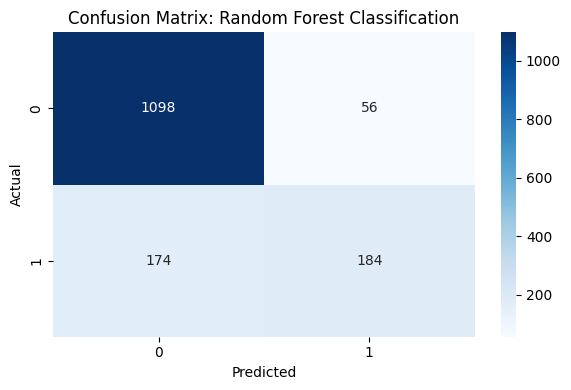

In [102]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Random Forest Classification')
plt.tight_layout()
plt.show()

**Observe the true positive rate is 51% (recall score)**

### Feature importances analysis

The top 5 most important feature are:
9       Humidity3pm
11      Pressure3pm
10      Pressure9am
4          Sunshine
5     WindGustSpeed
Name: Feature, dtype: object


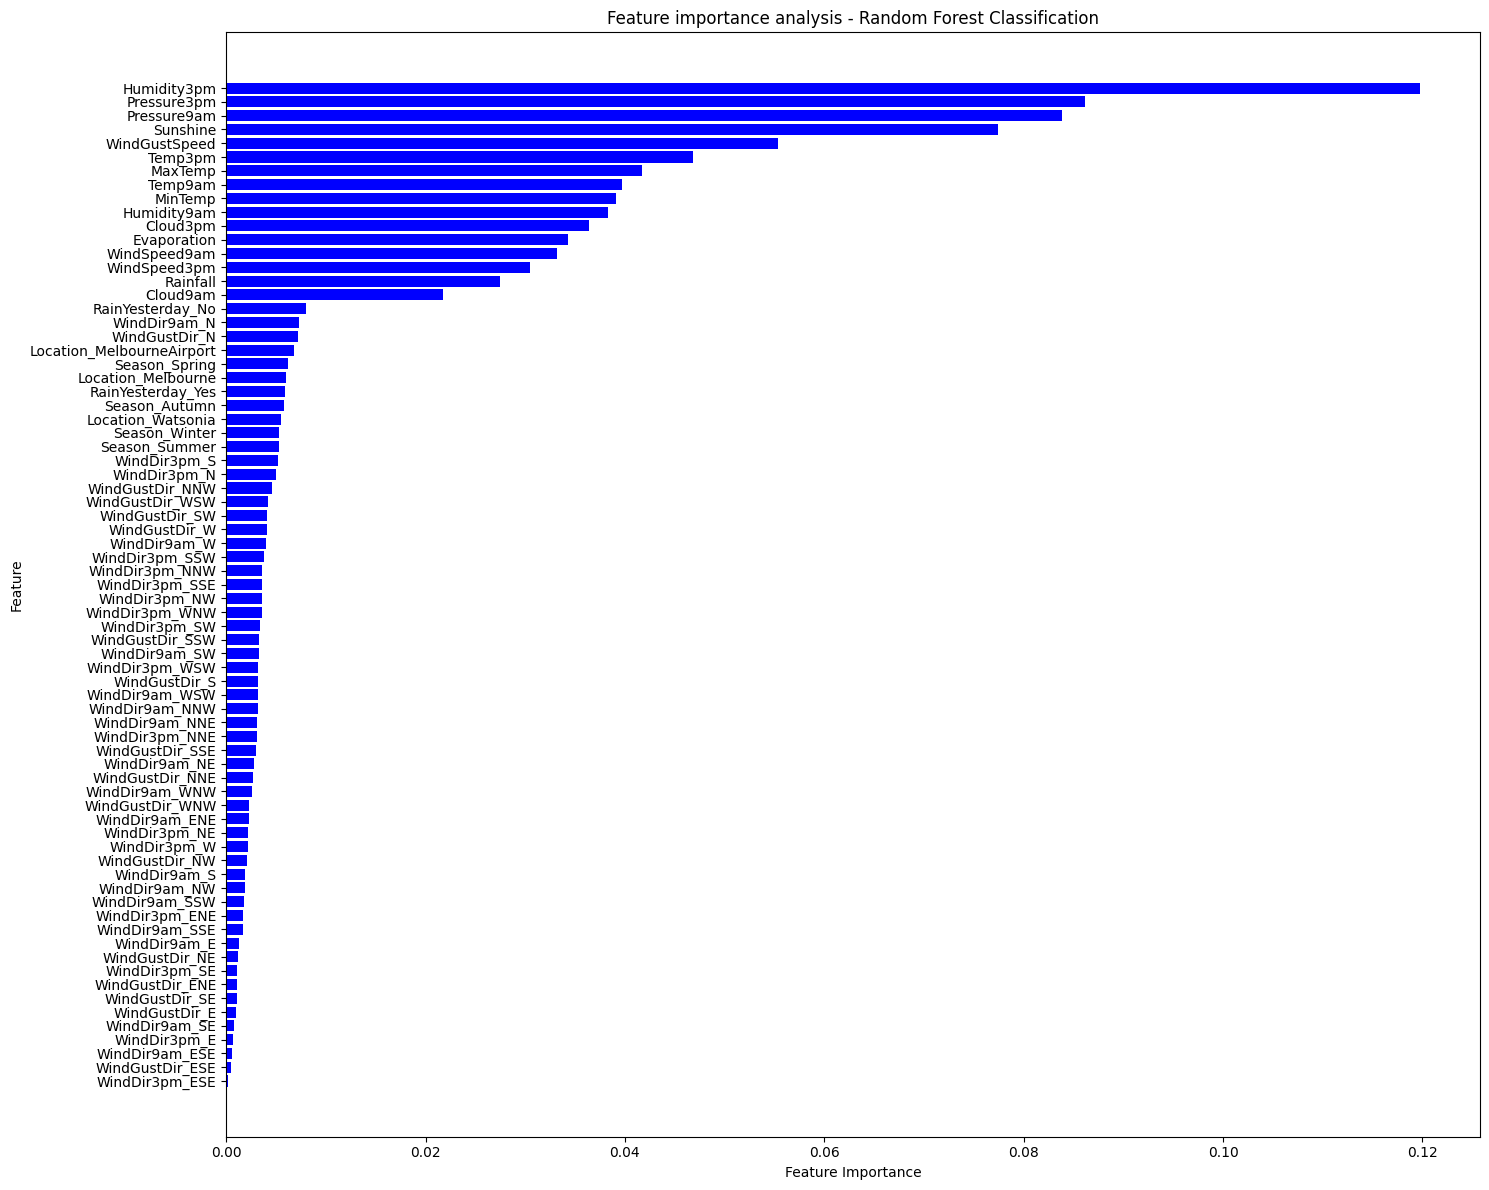

In [103]:
# Retrieve all numerical features and categorical features
categorical_features_list = list(model.best_estimator_['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
total_features = numerical_features + categorical_features_list

# Retrieve feature importance value
feature_importances = model.best_estimator_['classifier'].feature_importances_

# Create dataframe with features and feature importances
df_feature_importances_rf = pd.DataFrame({
    'Feature': total_features,
    'Feature Importance': feature_importances
}).sort_values(by='Feature Importance', ascending=False)


top_5 = df_feature_importances_rf.head()['Feature']
print(f'The top 5 most important feature are:\n{top_5}')

# Get top 20 features for visualization
df_top20 = df_feature_importances_rf.head(20)

plt.figure(figsize=(15, 12))
plt.barh(df_feature_importances_rf['Feature'], df_feature_importances_rf['Feature Importance'], color='blue')

plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.title('Feature importance analysis - Random Forest Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Prediction with logistic regression

In [104]:
pipeline.set_params(classifier=LogisticRegression(random_state=42))

model.estimator = pipeline

param_grid_lr = {
    'classifier__solver': ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': [None, 'balanced']
}

model.param_grid = param_grid_lr

model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pr...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainYesterday',
                                                                          'Season'])])),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             param_grid={'classifier__class_weight': [None, 'balanced'],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear']},
             scoring='accuracy', verbose=2)

In [105]:
y_pred_lr = model.predict(X_test)

In [106]:
# Classification report

classification_report_lr = classification_report(y_test, y_pred_lr)
print(classification_report_lr)

              precision    recall  f1-score   support

          No       0.86      0.93      0.89      1154
         Yes       0.68      0.51      0.58       358

    accuracy                           0.83      1512
   macro avg       0.77      0.72      0.74      1512
weighted avg       0.82      0.83      0.82      1512



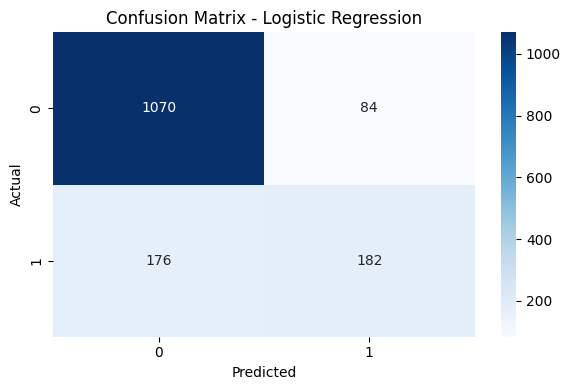

In [107]:
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 4))

sns.heatmap(conf_matrix_lr,cmap='Blues', annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

In [108]:
evaluation_score_lr = model.score(X_test, y_test)
'''
It is equivelent to below
y_pred = model.predict(X_test)
accuracy_score_ = accuracy_score(y_test, y_pred)
'''
print(f'The final evaluation score with thg best model: {evaluation_score_lr:.3f}')

The final evaluation score with thg best model: 0.828


**Random Forest Classification**
- Accuracy: 0.848
- True positive rate: 0.51

**Logistic Regression**
- Accuracy: 0.828
- True positive rate: 0.51